# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
# parsing the raw data using read_csv
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [4]:
# showing the data types of each variable in the dataframe
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [5]:
# get the mean of each variable
bikes_df_raw.mean(axis = 0)

season          2.501640
hour           11.546752
holiday         0.028770
weekday         3.003683
workingday      0.682721
weather         1.425283
temp            0.496987
atemp           0.475775
hum             0.627229
windspeed       0.190098
casual         35.676218
registered    153.786869
dtype: float64

In [6]:
# determine the minimum of each variable
bikes_df_raw.min(axis = 0)

dteday        2011-01-01
season                 1
hour                   0
holiday                0
weekday                0
workingday             0
weather                1
temp                0.02
atemp                  0
hum                    0
windspeed              0
casual                 0
registered             0
dtype: object

In [7]:
# show the maximum of each variable
bikes_df_raw.max(axis = 0)

dteday        2012-12-31
season                 4
hour                  23
holiday                1
weekday                6
workingday             1
weather                4
temp                   1
atemp                  1
hum                    1
windspeed         0.8507
casual               367
registered           886
dtype: object

The data types certainly make sense because of the way that each of these variables have been defined as normalized indices or boolean values. The means also reflect the tendencies of each variable. For example, the season is slightly skewed toward 4 rather than 2 because more bike rides should be taken toward the summer months rather than cold months. Finally, the ranges make sense because there should be 0s for each of these vairables other than season and temperature, and they also reach reasonable peaks.

**1.2 Notice that the variable in column...**

In [8]:
# convert the dates to datetime
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw.dteday)
# check that the conversion is successful
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3 Create three new columns in the dataframe:...**

In [9]:
# set year with respect to 2011, get the month, and sum casual and registered for "counts"
bikes_df_raw['year'] = bikes_df_raw['dteday'].dt.year - 2011
bikes_df_raw['month'] = bikes_df_raw['dteday'].dt.month
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [10]:
# aggregate by day, getting the requested medians, maximums, means, and totals for each variable. some medians don't matter as it's the same variable throughout
bikes_by_day = bikes_df_raw.groupby('dteday').agg({
    'weekday': np.median,
    'weather': np.max,
    'season': np.median,
    'temp': np.mean,
    'atemp': np.mean,
    'windspeed': np.mean, 
    'hum': np.mean,
    'casual': np.sum, 
    'registered': np.sum,
    'counts': np.sum
})
bikes_by_day.head()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


In [11]:
# aggregate by which weekday the hour's stats are from, getting the respective stats for each column
bikes_by_weekday = bikes_by_day.groupby('weekday').agg({
    'weekday': np.median,
    'casual': np.sum,
    'registered': np.sum
})
bikes_by_weekday

,weekday,casual,registered
weekday,,,
0,0,140521,303506
1,1,70784,384719
2,2,57843,411266
3,3,57319,415729
4,4,61460,423935
5,5,78238,409552
6,6,153852,323955


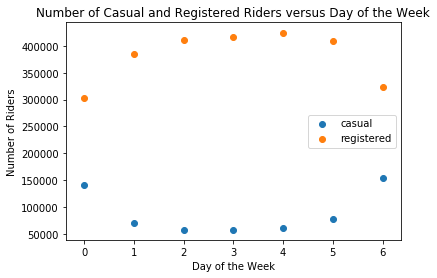

In [12]:
# puts casual riders and registered riders by weekday on the same scatterplot
plt.scatter(bikes_by_weekday['weekday'], bikes_by_weekday['casual'], label = 'casual')
plt.scatter(bikes_by_weekday['weekday'], bikes_by_weekday['registered'], label = 'registered')
plt.xlabel("Day of the Week")
plt.ylabel("Number of Riders")
plt.title("Number of Casual and Registered Riders versus Day of the Week")
plt.legend()
plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

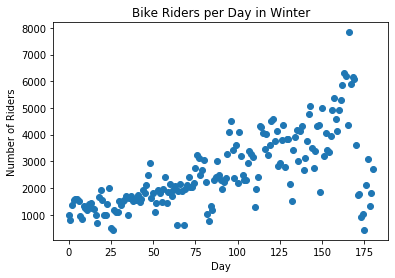

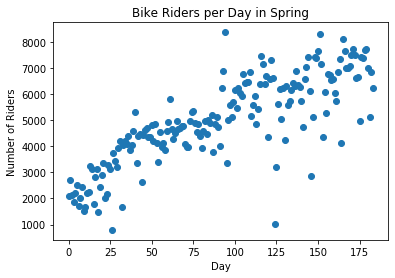

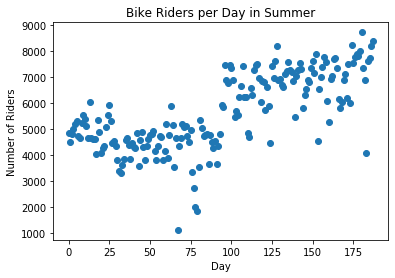

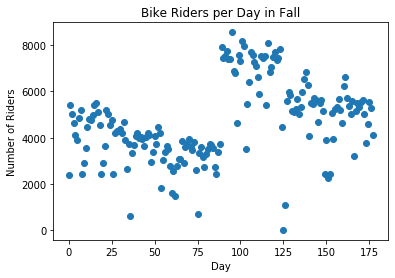

In [13]:
# groups the rides by season
seasonGroups = bikes_by_day.groupby('season')
win, spr, summ, fall = seasonGroups.get_group(1), seasonGroups.get_group(2), seasonGroups.get_group(3), seasonGroups.get_group(4)

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for title, season in zip([win, spr, summ, fall], seasons):
    plt.scatter(np.arange(len(title['counts'])), title['counts'])
    plt.title('Bike Riders per Day in {}'.format(season))
    plt.xlabel('Day')
    plt.ylabel('Number of Riders')
    plt.show()

In [14]:
def outlier_finder(df):
    outliers = []
    firstQuart, thirdQuart = df['counts'].quantile(0.25), df['counts'].quantile(0.75)
    IQR = thirdQuart-firstQuart
    for value in df['counts']:
        if value < (firstQuart-1.5*IQR) or value > (thirdQuart + 1.5*IQR):
            outliers.append(value)
    return outliers
print("Outlier quantities in winter (number of riders):", outlier_finder(win))
print("Outlier quantities in spring (number of riders):", outlier_finder(spr))
print("Outlier quantities in summer (number of riders):", outlier_finder(summ))
print("Outlier quantities in fall (number of riders):", outlier_finder(fall))

Outlier quantities in winter (number of riders): [7836]
Outlier quantities in spring (number of riders): []
Outlier quantities in summer (number of riders): []
Outlier quantities in fall (number of riders): [22]


In [15]:
win.loc[win['counts'] == outlier_finder(win)[0]]

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836


In [16]:
fall.loc[fall['counts'] == outlier_finder(fall)[0]]

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-10-29,1,3,4,0.44,0.4394,0.3582,0.88,2,20,22


The outlier on March 17, 2012 seems to be a result of a combination of the very high temperature that day and the holiday of St. Patrick's Day, rendering more people free to ride on their bike. The outlier of low bike riders on October 29 of 2012 may be a result of Hurricane Sandy, which profoundly affected the East Coast.

**2.3 Convert the categorical attributes...**

In [17]:
# your code here
bikes_df = pd.get_dummies(bikes_df_raw, columns = ['season', 'month', 'weekday', 'weather'], drop_first = True)
bikes_df.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [18]:
# splits the data using the train_test_split function
bikes_train, bikes_test = train_test_split(bikes_df, test_size = 0.5, stratify = bikes_df['dteday'].dt.month, random_state = 90)

In [19]:
bikes_train.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
17280,2012-12-27,21,0,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
6747,2011-10-13,17,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
13948,2012-08-09,9,0,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
11005,2012-04-08,17,0,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
9322,2012-01-29,8,0,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


In [20]:
bikes_test.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
17336,2012-12-30,5,0,0,0.26,0.2273,0.48,0.2985,0,2,...,1,0,0,0,0,0,0,1,0,0
11486,2012-04-28,19,0,0,0.36,0.3485,0.71,0.1343,29,110,...,0,0,0,0,0,0,1,0,1,0
16889,2012-12-11,12,0,1,0.36,0.3182,0.53,0.4478,13,213,...,1,0,1,0,0,0,0,1,0,0
9601,2012-02-10,0,0,1,0.28,0.3030,0.65,0.0896,4,39,...,0,0,0,0,0,1,0,1,0,0
13508,2012-07-22,1,0,0,0.60,0.5455,0.88,0.1642,31,99,...,0,0,0,0,0,0,0,1,0,0


**2.5 Although we asked you to create your train and test set...**

In [21]:
# reads in both of the BSS csv files and drops one column from each
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')
BSS_train = BSS_train.drop(columns = 'dteday')
BSS_test = BSS_test.drop(columns = 'dteday')

In [22]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


In [23]:
BSS_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,0,2,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,29,110,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,13,213,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,4,39,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,31,99,...,0,0,0,0,0,0,0,1,0,0


**2.6 Use pandas' `scatter_matrix` command to visualize...**

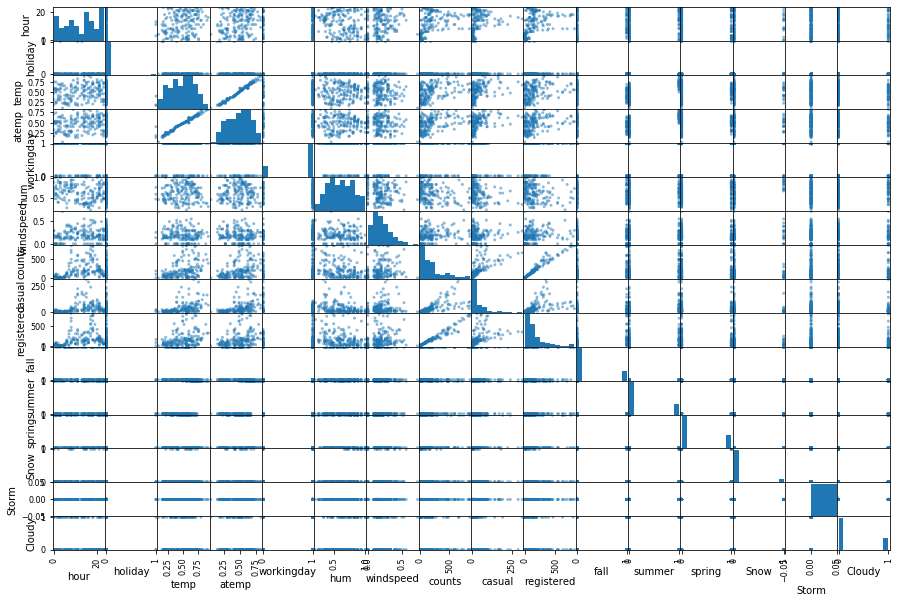

In [24]:
# uses scatter matrix on relevant variables in BSS_train
df_scatter = BSS_train[['hour', 'holiday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed', 'counts', 'casual', 'registered', 'fall', 'summer', 'spring', 'Snow', 'Storm', 'Cloudy']].copy()
import warnings
warnings.simplefilter(action='ignore', category=Warning)
pd.plotting.scatter_matrix(df_scatter.sample(frac = .02), figsize = (15, 10));

We see a strong, positive correlation between counts and registered and casual riders, which makes sense as this is a directly dependent statistic. Moreover, we see a strong, positive correlation between atemp (apparent temperature) and temp, a very logical correlation here. We see somewhat of a positive correlation between temperature and counts. This makes sense because warmer weather tends to lead in a higher propensity to take out a bike.

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

In [25]:
# groups by each hour of the day and determines the average number of casual and registered riders
BSS_trainHour = BSS_train.groupby('hour').agg({
    'hour': np.median,
    'casual': np.mean,
    'registered': np.mean
})
BSS_trainHour.head()

,hour,casual,registered
hour,,,
0,0,11.056980,43.774929
1,1,6.357513,26.116580
2,2,4.674863,17.877049
3,3,2.798956,9.370757
4,4,1.277286,5.011799


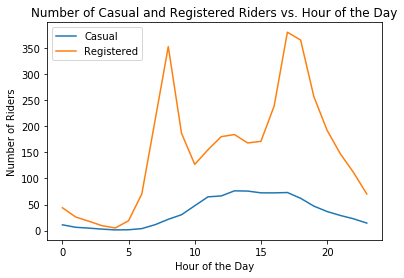

In [26]:
# plots average casual and registered riders for each hour of the day
# we chose a line graph here to show progression throughout the day rather than a simple, distinct scatter plot
plt.plot(BSS_trainHour['hour'], BSS_trainHour['casual'], label = 'Casual')
plt.plot(BSS_trainHour['hour'], BSS_trainHour['registered'], label = 'Registered')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Riders')
plt.title('Number of Casual and Registered Riders vs. Hour of the Day')
plt.legend()
plt.show()

We observe that registered riders have two peaks in bike usage-- the first being in the morning, likely on their regular commute to work, and the second being around 4-6 PM, likely around the time of their regular commute home from work. This makes sense since most registered riders will be regularly using the bikes to commute to and from work. On the other hand, the casual riders rise throughout the day because they are probably on vacation or biking for leisure and can do it during the sunny hours of the day during which many of the registered riders are likely working.

**2.8 Use the weather related variables to show how each weather...** 

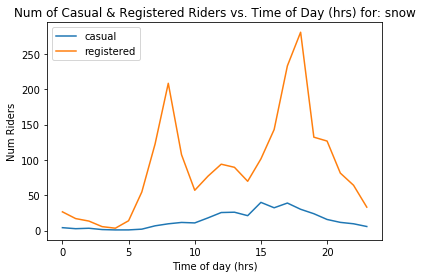

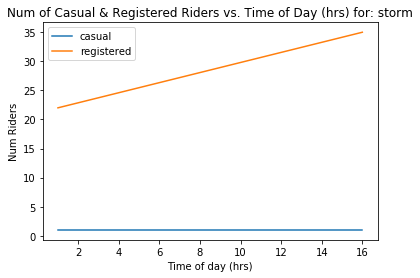

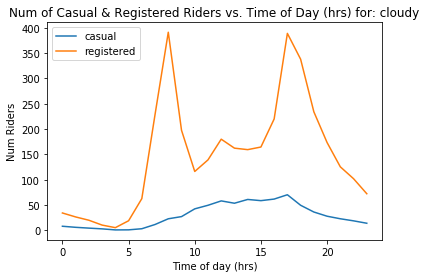

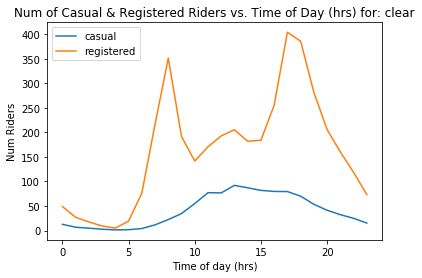

In [27]:
BSS_snow = BSS_train.loc[BSS_train['Snow'] == 1]
BSS_storm = BSS_train.loc[BSS_train['Storm'] == 1]
BSS_cloudy = BSS_train.loc[BSS_train['Cloudy'] == 1]
BSS_clear = BSS_train.loc[(BSS_train['Cloudy'] == 0) & (BSS_train['Storm'] == 0) & (BSS_train['Snow'] == 0)]

BSS_train_list = [BSS_snow, BSS_storm, BSS_cloudy, BSS_clear]

# makes a list of weather types to insert into the title
weathers = ['snow', 'storm', 'cloudy', 'clear']
# goes through each type of weather to generate the average ridership at each hour in that type of weather and put into line graph
for index, item in enumerate(BSS_train_list):
    BSS_train_hour = item.groupby("hour").agg({
        'hour': np.median,
        'casual': np.mean,
        'registered': np.mean })
    plt.plot(BSS_train_hour["hour"], BSS_train_hour["casual"], label = 'casual')
    plt.plot(BSS_train_hour["hour"], BSS_train_hour["registered"], label = 'registered')
    plt.legend()
    plt.title("Num of Casual & Registered Riders vs. Time of Day (hrs) for: " + weathers[index]) 
    plt.xlabel("Time of day (hrs)")
    plt.ylabel("Num Riders")
    plt.show()

There were only 2 stormy days, so no real patterns are able to determined from such a small sample. This is why the lines appear so linear. The other 3 plots (clear, cloudy, and snow) all seem to follow the same shaped distribution. Yet, there are important differences in these plots. While the number of registered riders is basically the same for clear and cloudy days, the number of casual riders is greater on clear days, as can be seen by comparing the blue dots from the bottom two graphs. Further, on snowy days, the number of both casual and registered riders decreases (approximately proportionally), as can be seen by comparing the y values of the points on the top graph to the bottom two graphs.

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [28]:
# your code here

y_train = BSS_train['counts']
y_test = BSS_test['counts']

# builds the x_matrix by dropping necessary columns and adding the row of 1s to the matrix
def build_data(df):
    x_matrix = df.copy().drop(columns = ['casual', 'registered', 'counts'])
    x_matrix = sm.add_constant(x_matrix)
    return x_matrix
X_train = build_data(BSS_train)
X_test = build_data(BSS_test)

In [29]:
# fits a model using the y_train and x_train data as endogenous and exogenous variables, respectively
fitted_model_1 = OLS(endog = y_train, exog = X_train, hasconst = True).fit()
fitted_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:51:48   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [30]:
scoreTrain = fitted_model_1.rsquared
scoreTest = r2_score(y_test, fitted_model_1.predict(X_test))
print("The R^2 score on the train set is {}.".format(scoreTrain))
print("The R^2 score on the test set is {}".format(scoreTest))

The R^2 score on the train set is 0.4115699822629325.
The R^2 score on the test set is 0.40072109229413466


**3.2 Examine the estimated coefficients and report...**

In [31]:
# your code here
fitted_model_1.pvalues

const          5.319401e-03
hour          6.967036e-200
holiday        2.214061e-02
year          3.862196e-142
workingday     1.828978e-03
temp           9.243128e-06
atemp          1.229662e-02
hum            5.926590e-90
windspeed      1.539993e-01
spring         1.510519e-07
summer         4.168321e-02
fall           6.554799e-14
Feb            1.578743e-01
Mar            1.780470e-01
Apr            3.897799e-04
May            2.023805e-04
Jun            1.392848e-07
Jul            3.606677e-09
Aug            1.084419e-04
Sept           2.287343e-01
Oct            2.032957e-01
Nov            6.623427e-03
Dec            4.454012e-02
Mon            3.748296e-01
Tue            9.985666e-01
Wed            5.889066e-01
Thu            1.651851e-01
Fri            4.679592e-01
Sat            2.255964e-02
Cloudy         5.992922e-02
Snow           1.092443e-05
Storm          6.257678e-01
dtype: float64

The columns with p-values of less than .05 are const, hour, holiday, year, workingday, temp, atemp, hum, spring, summer, fall, Apr, May, Jun, Jul, Aug, Nov, Dec, Sat, and Snow.

**3.3 You should see some strange estimates for the predictors representing months...** 

The July estimate has a very high magnitude with -90.8965 as its coefficient. What this means is that knowing you are in July decreases the amount of predicted bikes registered by 90.8965 bikes. This may be happening due to the sweletering heat that tends to accompany July, which is why knowing that you are in July significantly decreases the amount of predicted bikes being used on a daily basis.

**3.4 To diagnose the model, make two plots:...**

Text(0.5, 1.0, 'Histogram of Residuals')

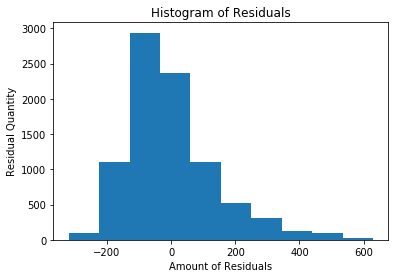

In [32]:
# generates predictions from the fitted model 1 and determines residuals by subtracting predicted from observed in the training
predictions = fitted_model_1.predict(X_train)
residuals = y_train-predictions
plt.hist(residuals)
plt.xlabel('Amount of Residuals')
plt.ylabel('Residual Quantity')
plt.title('Histogram of Residuals')

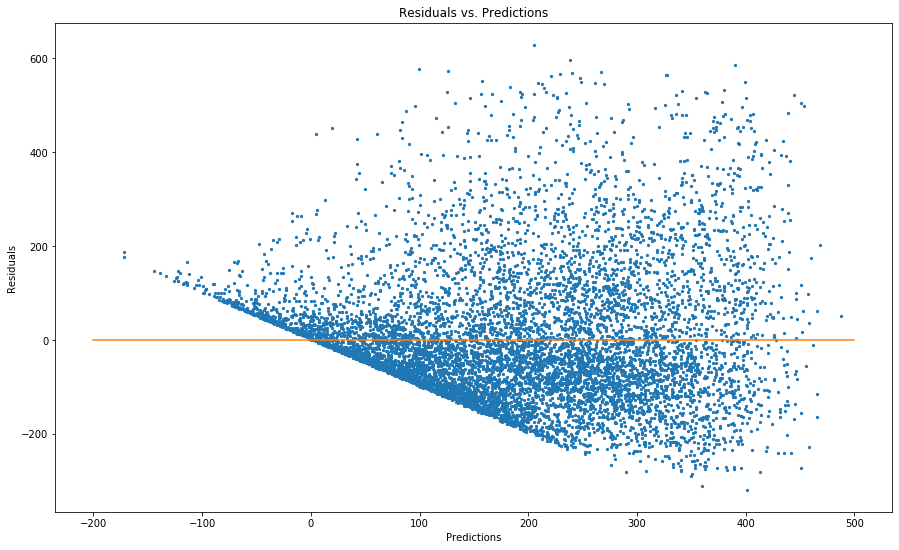

In [33]:
fig, ax = plt.subplots(figsize = (15, 9))
# plots the residuals vs. the predictions
ax.scatter(predictions, residuals, s = 5)
ax.plot(np.linspace(-200, 500, 1), 0)
ax.set_xlabel('Predictions')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs. Predictions')
ax.plot(np.linspace(-200, 500, 100), np.zeros(100))

These plots reveal that we cannot make the OLS assumption of normality for this model because the residuals are not distributed normally. Since the residuals are not distribuetd normally, we know that a linear model cannot accurately model the pattern in the original data, because the counts of riders do not actually then vary linearly with each of the factors in the model. So, a linear model cannot hold. We also know that the variance in the model is not constant because at different prediction levels there are differing amounts of variance.

**3.5 Perhaps we can do better via a model...**
**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [34]:
# adds polynomial terms, specifically squared terms, for three of the variables
X_train_poly = X_train.copy()
X_train_poly['temp_squared'] = X_train_poly['temp']**2
X_train_poly['hour_squared'] = X_train_poly['hour']**2
X_train_poly['hum_squared'] = X_train_poly['hum']**2
X_train_poly.head()

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,temp_squared,hour_squared,hum_squared
0,1.0,21,0,1,1,0.24,0.2273,0.60,0.2537,0,...,0,1,0,0,1,0,0,0.0576,441,0.3600
1,1.0,17,0,0,1,0.62,0.5758,0.83,0.2537,0,...,0,1,0,0,0,1,0,0.3844,289,0.6889
2,1.0,9,0,1,1,0.76,0.7273,0.66,0.1642,0,...,0,1,0,0,0,0,0,0.5776,81,0.4356
3,1.0,17,0,1,0,0.62,0.6061,0.22,0.2985,1,...,0,0,0,0,0,0,0,0.3844,289,0.0484
4,1.0,8,0,1,0,0.18,0.1970,0.40,0.1343,0,...,0,0,0,0,0,0,0,0.0324,64,0.1600


In [35]:
fitted_model_2 = OLS(endog= y_train, exog=X_train_poly, hasconst=True).fit()
fitted_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:51:49   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour            40.2211      0.840     47.896      0.000      38.575      41.867
holiday        -14.0310      7.656     -1.833      0.067     -29.039       0.977
year            83.2098      2.781     29.921      0.000      77.758      88.661
workingday      13.2241      3.212      4.117      0.000       6.928      19.520
temp            46.0096     78.769      0.584      0.559    -108.397     200.416
atemp          148.5309     61.182      2.428      0.015      28.599     268.463
hum             42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed      -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring          46.8322      8.714      5.374      0.000      29.750      63.914
summer          25.4085     10.202      2.490      0.013       5.410      45.407
fall            74.7289      8.643      8.646      0.000      57.787      91.671
Feb             -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar              9.1429      7.906      1.156      0.248      -6.355      24.641
Apr            -12.2792     11.781     -1.042      0.297     -35.373      10.814
May            -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun            -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul            -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug            -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept            11.0442     12.519      0.882      0.378     -13.495      35.584
Oct             -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov            -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec            -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon             -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue              0.9441      3.753      0.252      0.801      -6.412       8.301
Wed             -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu             -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri              3.8028      3.671      1.036      0.300      -3.393      10.999
Sat             18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy          -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow           -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm           34.1383     90.378      0.378      0.706    -143.024     211.301
temp_squared   140.6804     46.276      3.040      0.002      49.968     231.393
hour_squared    -1.3881      0.034    -40.654      0.000      -1.455      -1.321
hum_squared   -126.8873     36.621     -3.465      0.001    -198.673     -55.102
=====

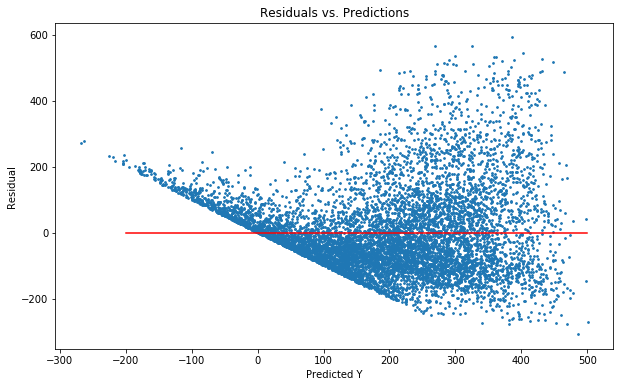

In [36]:
predictions2 = fitted_model_2.predict(X_train_poly)
residuals = y_train - predictions2
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(predictions2, residuals, s=3)
ax.set_xlabel("Predicted Y")
ax.set_ylabel("Residual")
ax.set_title("Residuals vs. Predictions")
xgrid = np.linspace(-200, 500, 100)

ax.plot(xgrid, np.zeros(100), color = 'red');

In [37]:
scoreTrain2 = fitted_model_2.rsquared
print("The R^2 score on the train set is {}.".format(scoreTrain2))

The R^2 score on the train set is 0.5084917032962087.


These polynomial terms are important because they reduce error in the predictions of the values. The R^2 scores improved. As temp and hour increase, the predicted ridership increases as the coefficients are positive. However, as humidity increases, the predicted ridership decreases because the coefficient is negative.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [38]:
# your drops certain terms from the dataframe
X_train_drop = X_train.copy().drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
X_train_drop.head()

,const,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,21,0,1,0.24,0.60,0.2537,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,1.0,17,0,0,0.62,0.83,0.2537,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1.0,9,0,1,0.76,0.66,0.1642,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,17,0,1,0.62,0.22,0.2985,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,8,0,1,0.18,0.40,0.1343,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
fitted_model_3 = OLS(endog = y_train, exog = X_train_drop, hasconst = True).fit()
fitted_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:51:49   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this model, the estimates are more sensible because the seasons do not have an apparently enormous impact on the number of bike registrations per day. Previously, the season was highly colinear with the humidity, making it seem like each of the seasons as well as the humidity had a significant impact on the ridership. Now, it seems like the humidity, not the season, has a significant influence on ridership because even without seasons in the model, it still has a very high magnitude of a coefficient. Multicolinearity can make variables that are not directly related to the response variable seem like they have a disproportionate impact on the response variable simply because these variables are colinear with other explanatory variables that are correlated to the response variable. People are not increasing or decreasing their ridership in response to the season, but rather in response to the humidity levels. We prove this by dropping the seasons and showing that humidity is the underlying driver for ridership, more than the seasons themselves.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [40]:
for var in ['workingday', 'atemp', 'spring', 'summer', 'fall']:
    # tries to drop the column from training and testing data, catches error if not
    try:
        BSS_train = BSS_train.drop(columns = [var])
    except:
        print(var + 'not in training dataframe')
        pass
    try:
        BSS_test = BSS_test.drop(columns = [var])
    except:
        print(var + ' in test dataframe')

# we only want predictors in our training x matrix and testing x matrix, so we drop response variables
X_train = BSS_train.drop(columns = ['counts', 'registered', 'casual'])
X_test = BSS_test.drop(columns = ['counts', 'registered', 'casual'])

**4.2 Write a function to standardize...**

In [41]:
def standardize(df, col: list):
    # uses scaler object to scale the temporary dataframe
    copy = df.copy()
    scaler = StandardScaler()
    copy[col] = scaler.fit_transform(copy[col])
    
    return copy

# uses binary_columns as defined above
binary_columns = ['holiday', 'workingday','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

# finds the columns other than binary columns (non-binary) and works with those
non_bin_col = X_train.columns.difference(binary_columns)
practice_X_train = BSS_train.drop(columns = ['counts', 'casual', 'registered'])
practice_X_train_scaled = standardize(practice_X_train, non_bin_col)
practice_X_train_scaled.describe()

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,2.762461e-17,0.029347,-2.754411e-16,-7.622961e-17,-4.148227e-16,-5.604141e-17,0.077224,0.084705,0.082748,0.085626,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000058e+00,0.168788,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.266962,0.278458,0.275517,0.279826,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666359e+00,0.000000,-1.006813e+00,-2.474192e+00,-3.251974e+00,-1.546636e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042663e-01,0.000000,-1.006813e+00,-8.122824e-01,-7.554808e-01,-6.987336e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782674e-02,0.000000,9.932327e-01,1.867233e-02,-2.733697e-02,2.746035e-02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.199197e-01,0.000000,9.932327e-01,8.496271e-01,8.048274e-01,5.118601e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638331e+00,1.000000,9.932327e-01,2.511537e+00,1.949053e+00,5.355858e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [42]:
def powerUp(df, columns, deg):
    # to prevent modifying the original dataframe
    df_temp = df.copy()
    for exp in range(2, deg + 1): 
        for col in columns:
            df_temp['{}^{}'.format(col, str(exp))] = df_temp[col]**exp
            
    return df_temp

practice_X_train_poly = powerUp(practice_X_train_scaled, ['temp', 'hum', 'windspeed', 'hour'], 3)
practice_X_train_poly.columns, practice_X_train_poly.head()

(Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
        'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
        'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2',
        'hum^2', 'windspeed^2', 'hour^2', 'temp^3', 'hum^3', 'windspeed^3',
        'hour^3'],
       dtype='object'),
        hour  holiday      year      temp       hum  windspeed  Feb  Mar  Apr  \
 0  1.350966        0  0.993233 -1.331629 -0.131358   0.511860    0    0    0   
 1  0.776238        0 -1.006813  0.641888  1.064879   0.511860    0    0    0   
 2 -0.373220        0  0.993233  1.368974  0.180704  -0.214334    0    0    0   
 3  0.776238        0  0.993233  0.641888 -2.107748   0.875363    0    0    1   
 4 -0.516902        0  0.993233 -1.643237 -1.171563  -0.456939    0    0    0   
 
    May  ...  Snow  Storm    temp^2     hum^2  windspeed^2    hour^2    temp^3  \
 0    0  ...     0      0  1.773236  0.017255     0.262001  1.825110 -2.361

In [43]:
practice_X_train_scaled

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.776238,0,0.993233,0.641888,-2.107748,0.875363,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.516902,0,0.993233,-0.085197,0.232714,-0.698734,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,-1.091631,0,-1.006813,-1.539368,-0.183368,0.270066,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,0.776238,0,-1.006813,2.096059,-1.743676,-0.698734,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0.201509,0,-1.006813,-0.396805,0.232714,-0.214334,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9,0.057827,0,-1.006813,0.641888,-1.431614,-1.546636,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


**4.4 Write code to add interaction terms to the model...**

In [44]:
# takes in a dataframe, continuous variable names, and dummy variable names to create interaction terms
def interaction(df, cont, dummy):
    copy = df.copy()
    for dum in dummy:
        for con in cont:
            copy['{}*{}'.format(con, dum)] = copy[con] * copy[dum]
    return copy

In [45]:
# tests our interaction function on practice_X_train_interactions to see that it works
continuous_features = ['temp', 'hum', 'windspeed']
dummy_features = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept','Oct','Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
practice_X_train_interactions = interaction(practice_X_train_poly, continuous_features, dummy_features)

practice_X_train_interactions.columns, practice_X_train_interactions.head()

(Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
        'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
        'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2',
        'hum^2', 'windspeed^2', 'hour^2', 'temp^3', 'hum^3', 'windspeed^3',
        'hour^3', 'temp*Feb', 'hum*Feb', 'windspeed*Feb', 'temp*Mar', 'hum*Mar',
        'windspeed*Mar', 'temp*Apr', 'hum*Apr', 'windspeed*Apr', 'temp*May',
        'hum*May', 'windspeed*May', 'temp*Jun', 'hum*Jun', 'windspeed*Jun',
        'temp*Jul', 'hum*Jul', 'windspeed*Jul', 'temp*Aug', 'hum*Aug',
        'windspeed*Aug', 'temp*Sept', 'hum*Sept', 'windspeed*Sept', 'temp*Oct',
        'hum*Oct', 'windspeed*Oct', 'temp*Nov', 'hum*Nov', 'windspeed*Nov',
        'temp*Dec', 'hum*Dec', 'windspeed*Dec', 'temp*Mon', 'hum*Mon',
        'windspeed*Mon', 'temp*Tue', 'hum*Tue', 'windspeed*Tue', 'temp*Wed',
        'hum*Wed', 'windspeed*Wed', 'temp*Thu', 'hum*Thu', 'windspeed*Thu',
   

**4.5 Combine all your code so far into a function named...**

In [46]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly = ['temp', 'hum','windspeed', 'hour'], 
                    target_col = 'counts', 
                    bad_columns = ['counts', 'registered', 'casual', 'dteday']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """ 
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    x_train = train_df
    x_val = val_df
    
    # loops through the bad columns and tries to drop them using a try-except
    for col in bad_columns:
        try:
            x_train = x_train.drop(columns = col)
        except:
            pass
        try:
            x_val = x_val.drop(columns = col)
        except:
            pass
    nonbinary_std = x_train.columns.difference(binary_columns)

    # take the x_train and standardize, add the power terms, add interaction terms, add constant
    x_train_std = standardize(x_train, nonbinary_std)
    x_train_poly = powerUp(x_train_std, columns_forpoly, degree)
    x_train_inter = interaction(x_train_poly, continuous_features, dummy_features)
    # do the same for the validation set
    x_train = sm.add_constant(x_train_inter)
    x_val_std = standardize(x_val, nonbinary_std)
    x_val_poly = powerUp(x_val_std, columns_forpoly, degree)
    x_val_inter = interaction(x_val_poly, continuous_features, dummy_features)
    x_val = sm.add_constant(x_val_inter)
    
    return x_train, y_train, x_val, y_val

**4.6 For each degree in 1 through 8...**

The R^2 score for a polynmial model of degree 1 is: 0.429
The R^2 score for a polynmial model of degree 2 is: 0.512
The R^2 score for a polynmial model of degree 3 is: 0.56
The R^2 score for a polynmial model of degree 4 is: 0.563
The R^2 score for a polynmial model of degree 5 is: 0.573
The R^2 score for a polynmial model of degree 6 is: 0.598
The R^2 score for a polynmial model of degree 7 is: 0.626
The R^2 score for a polynmial model of degree 8 is: 0.642


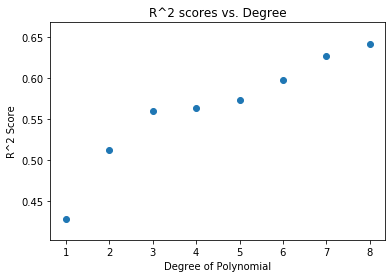

In [47]:
r2_scores = []
for deg in range(1,  9):
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train, BSS_test, deg)
    regression = sm.OLS(y_train, x_train).fit()
    predictions = regression.predict(x_val)
    r2_scores.append(r2_score(y_val, predictions))
    
for i in range(0, 8):
    print('The R^2 score for a polynmial model of degree {} is: {}'.format(i + 1, np.round(r2_scores[i], 3)))
plt.scatter(np.arange(1, 9), r2_scores)
plt.xlabel('Degree of Polynomial')
plt.ylabel('R^2 Score')
plt.title('R^2 scores vs. Degree')
plt.show()

**4.7 Discuss patterns you see in the results...**

Evidently, the R^2 score increases as the polynomial degree increases. I would therefore choose the degree 8 polynomial. It seems to have a high R^2 value relative to other polynomial degrees, which is a good sign. Some of this high R^2 score may be due to overfitting, which would leave it vulnerable to performing poorly with new test data. However, the model does well with the validation set, which is important. Therefore, it seems like the 8th degree model does the best job of any of these models of prediction.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [48]:
BSS_train['atemp'] = pd.read_csv('data/BSS_train.csv')['atemp']

# splits into training and validation subsets, with 80% in training and 20% in validation
BSS_train_sub, BSS_validation = train_test_split(BSS_train, test_size = 0.8)
scores = []
alphas = [.01, .05, .1, .5, 1, 5, 10, 50, 100]
for deg in range(1, 9):
    col_scores = []
    for alpha in alphas:
        x_train, y_train, x_val, y_val = get_design_mats(BSS_train_sub, BSS_validation, deg)
        regression = Ridge(alpha = alpha).fit(x_train, y_train)
        predictions = regression.predict(x_val)
        col_scores.append(r2_score(y_val, predictions))
    scores.append(col_scores)

scoreMatrix = pd.DataFrame(scores, columns = alphas)
scoreMatrix

,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0
0,0.405735,0.405778,0.405827,0.406105,0.406341,0.407364,0.407873,0.407475,0.404882
1,0.498031,0.498088,0.498151,0.498457,0.498652,0.499168,0.499338,0.498376,0.495900
2,0.539564,0.539583,0.539605,0.539739,0.539858,0.540156,0.539866,0.533437,0.524023
3,0.538969,0.539002,0.539039,0.539258,0.539438,0.539880,0.539638,0.533386,0.524295
4,0.550307,0.550332,0.550360,0.550529,0.550673,0.551133,0.551134,0.548162,0.543472
5,0.574116,0.574118,0.574119,0.574077,0.573943,0.571742,0.568846,0.558113,0.551337
6,0.599476,0.599514,0.599543,0.599248,0.598089,0.584611,0.572971,0.546234,0.536197
7,0.625368,0.625034,0.624592,0.620686,0.615935,0.592395,0.578461,0.548734,0.537449


# **5.2 Find the best-scoring degree and regularization combination.**

In [49]:
best = 0
# loops through the rows to find the best combination of lambda and degree
for lamb, degree in scoreMatrix.iterrows():
    if degree.max() > best:
        best = degree.max()
        bestScore = (lamb, degree.idxmax(), degree.max())
print("The best R^2 score is {}, which has a lambda of {} and a degree of {}".format(bestScore[2], bestScore[1], bestScore[0]))

The best R^2 score is 0.625368373179956, which has a lambda of 0.01 and a degree of 7


**5.3 It's time to see how well our selected model...**


In [50]:
x_train, y_train, x_val, y_val = get_design_mats(BSS_train_sub, BSS_validation, bestScore[0])
x_train = sm.add_constant(x_train)
x_val = sm.add_constant(x_val)
best_model = Ridge(alpha = bestScore[1]).fit(x_val, y_val)
print("The best model's R^2 score is {}".format(best_model.score(x_val, y_val)))

The best model's R^2 score is 0.64952729784275


##### This R^2 score is even better than the validation set score that helped us choose this model. The test set might just have observations that are more difficult to predict than the smaller validation set.

**5.4 Build a dataset with polynomial degree 1...**

In [51]:
x_train, y_train, x_val, y_val = get_design_mats(BSS_train_sub, BSS_validation, 1)
# creates OLS model using the training data
ols = OLS(y_train, x_train).fit()
# runs ridge and lasso regressions on the model built with the training data
ridge = RidgeCV(alphas = alphas).fit(x_train, y_train)
lasso = LassoCV(alphas = alphas, max_iter = 100000).fit(x_train, y_train)

**5.5 Plot histograms of the coefficients found...**

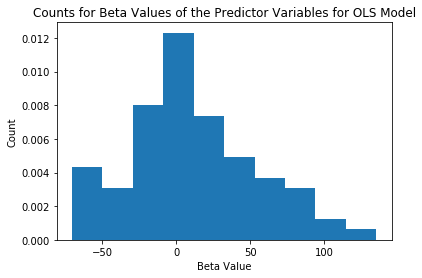

R^2 value: 0.466822223600422


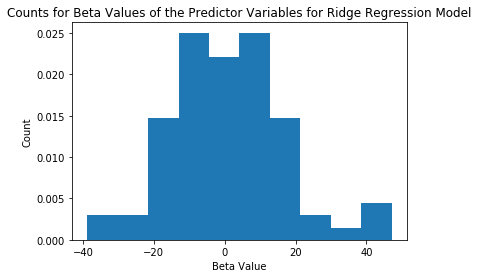

R^2 value: 0.40747526495417596


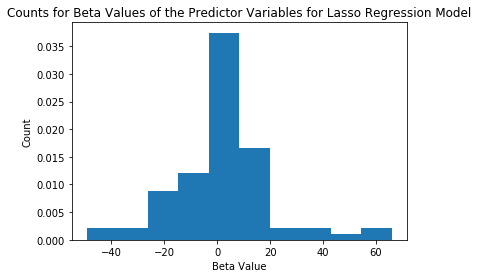

R^2 value: 0.40905966857353204


In [52]:
plt.hist(ols.params, density = True)
plt.xlabel('Beta Value')
plt.ylabel('Count')
plt.title('Counts for Beta Values of the Predictor Variables for OLS Model')
plt.show()
print("R^2 value: {}".format(ols.rsquared))

plt.hist(ridge.coef_, density = True)
plt.xlabel('Beta Value')
plt.ylabel('Count')
plt.title('Counts for Beta Values of the Predictor Variables for Ridge Regression Model')
plt.show()

print("R^2 value: {}".format(ridge.score(x_val, y_val)))

plt.hist(lasso.coef_, density = True)
plt.xlabel('Beta Value')
plt.ylabel('Count')
plt.title('Counts for Beta Values of the Predictor Variables for Lasso Regression Model')
plt.show()

print("R^2 value: {}".format(lasso.score(x_val, y_val)))

In terms of the magnitudes of the coefficients, we see in the OLS model that there is a much greater variance in the coefficient values, though they are mostly normally distributed with a slight skew right. In the ridge regression, there is a smaller distribution of values, with a similar general pattern of normality. Finally, for the Lasso regression, there is a definite mode around 0, and very few values of coefficients outside of it, though the other coefficients seem to take on high magnitudes.

**5.6 The plots above show the overall distribution of... **

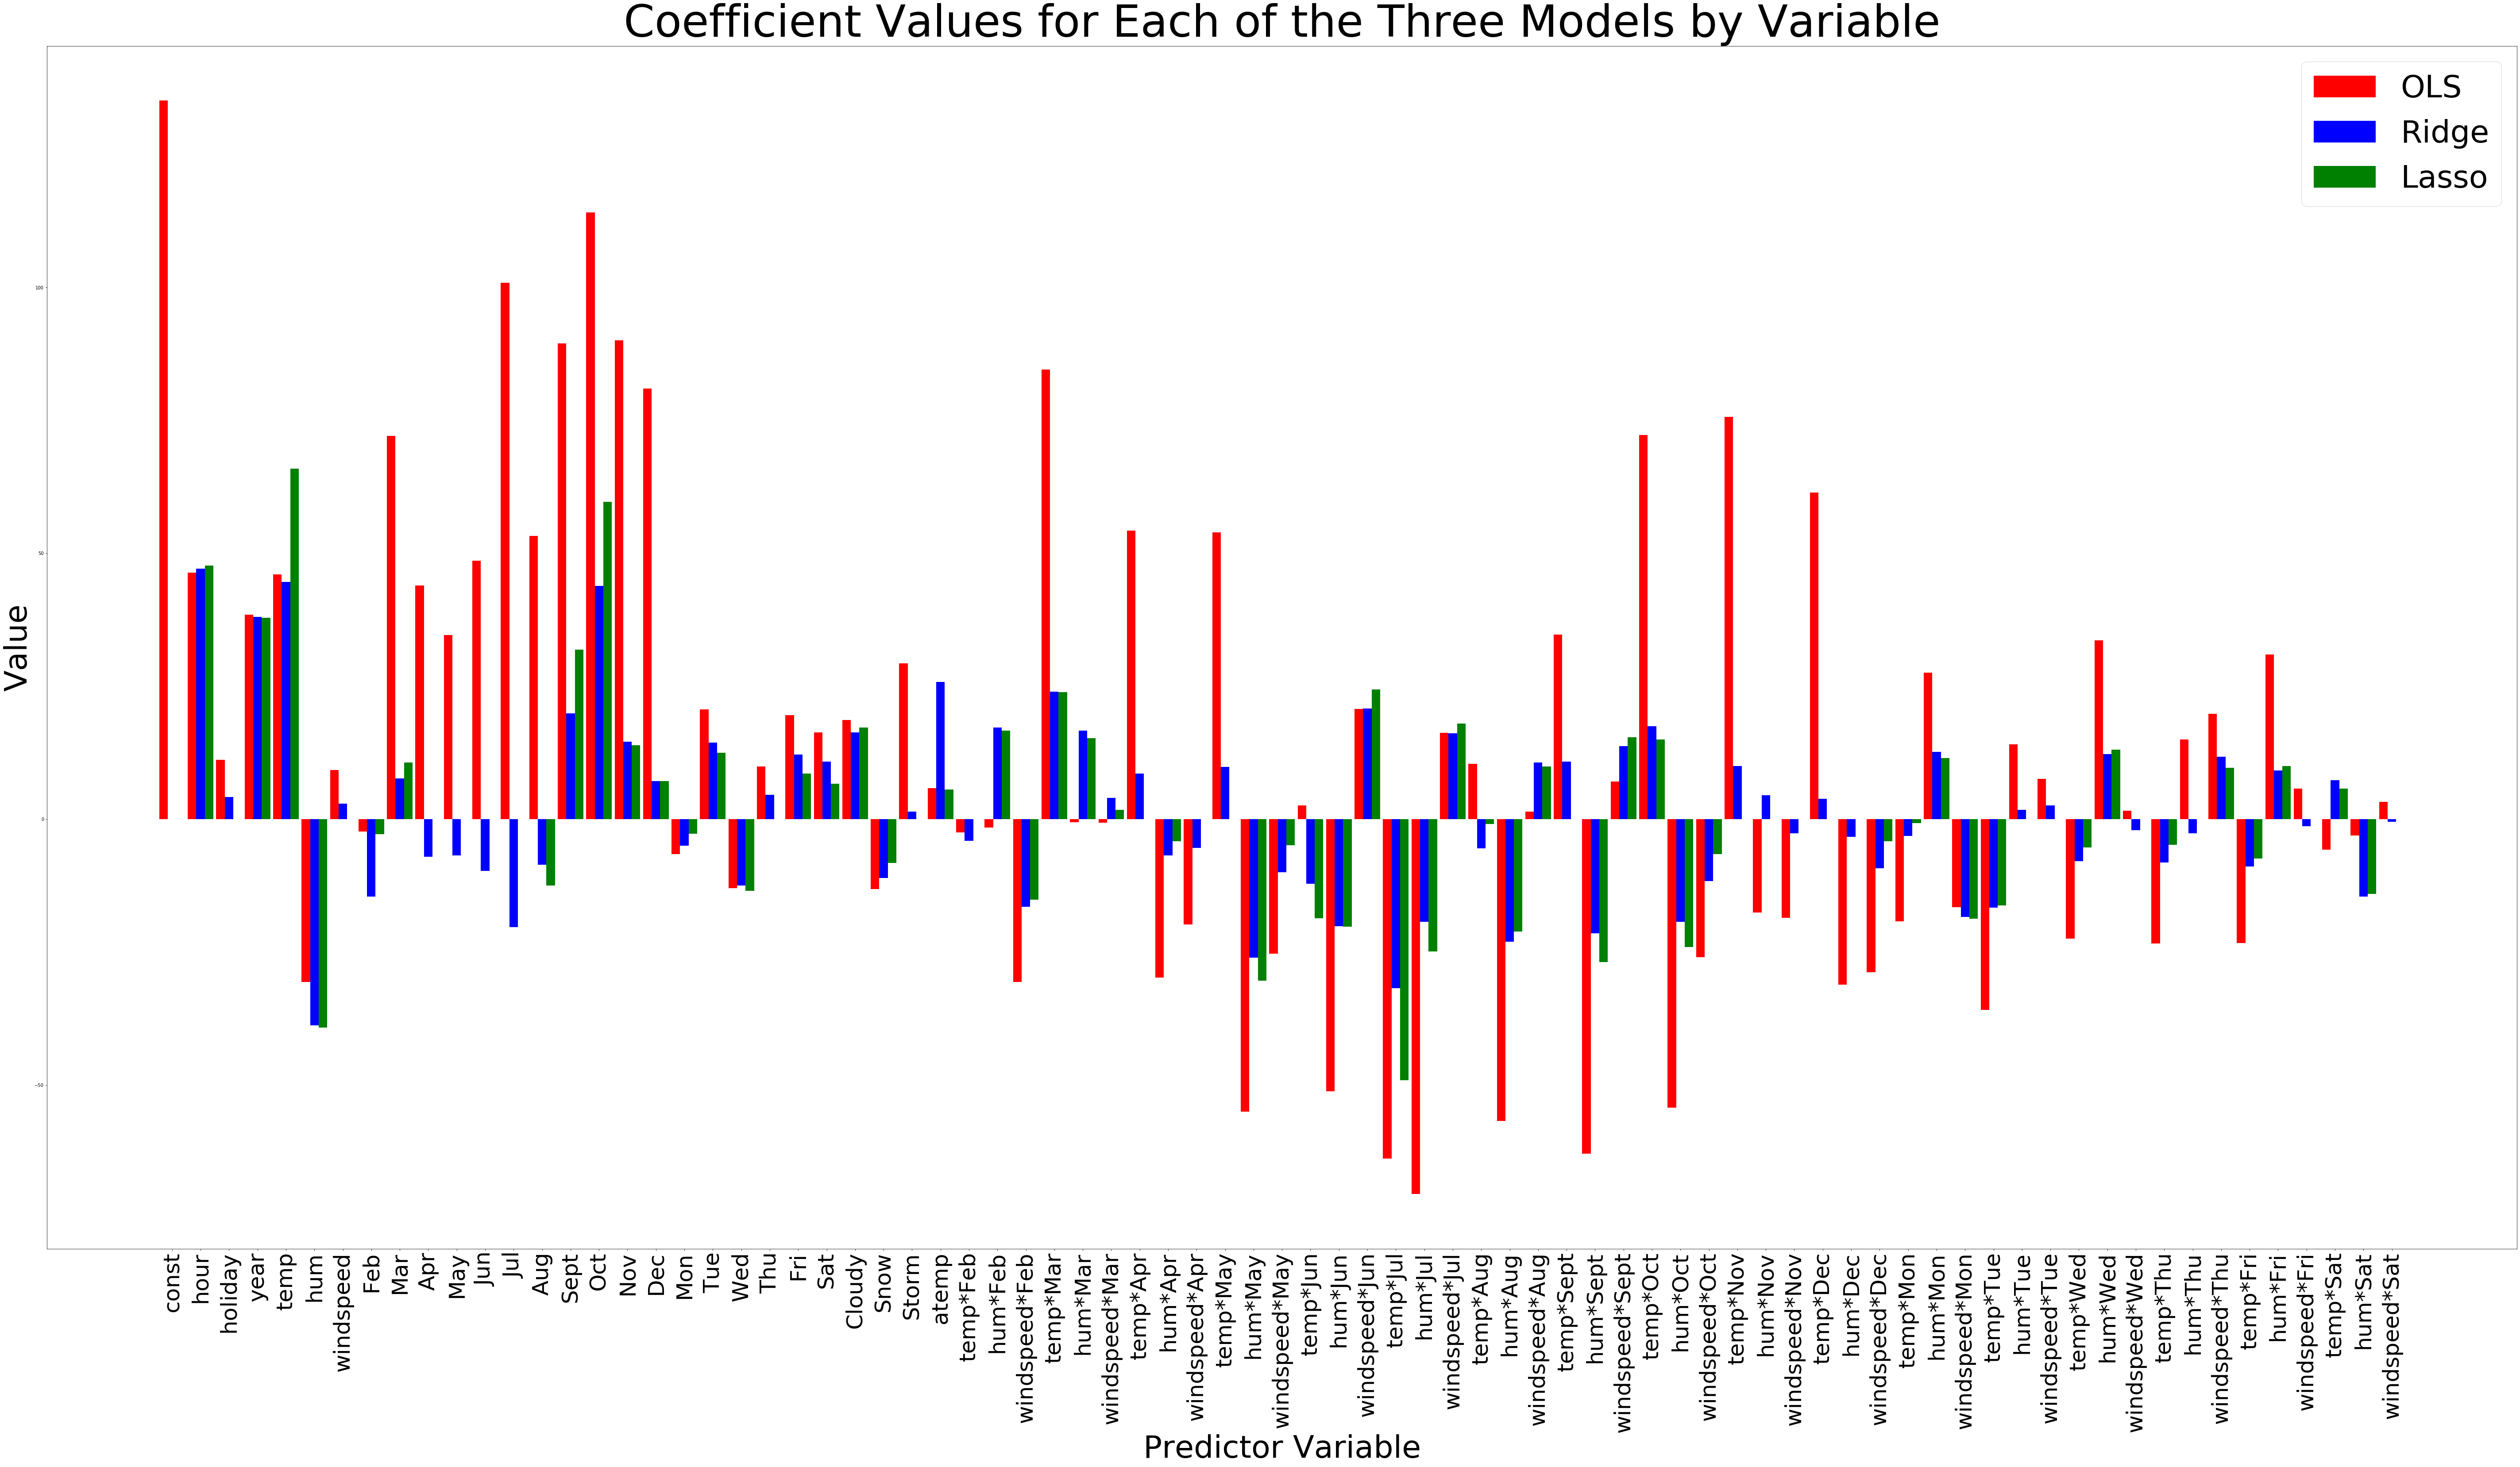

In [53]:
coefs = ols.params.index
fig, ax = plt.subplots(figsize = [100, 50])
length = np.arange(len(coefs))
width = .3
OLS_boxes = plt.bar(length, ols.params, width, color = 'red', label = 'OLS')
# separates out the separate histograms mathematically by shifting and using the amount of variables in each plot
Ridge_boxes = plt.bar(length + width, ridge.coef_, width, color='blue', label='Ridge')
Lasso_boxes = plt.bar(length + 2*width, lasso.coef_, width, color = 'green', label = 'Lasso')
plt.xlabel('Predictor Variable', fontsize = 70)
plt.ylabel('Value', fontsize = 70)
plt.title('Coefficient Values for Each of the Three Models by Variable', fontsize = 100)
plt.xticks(length + width, (ols.params.index), rotation = 90, fontsize = 50)
plt.legend(loc = 'best', fontsize = 70)
plt.show()


**5.7 What trends do you see...**

The OLS coefficients seem much larger relative to those of the other two. Also, most coefficients for a given variable are all of the same sign for all three models. It makes sense that the coefficients in OLS are much greater in magnitude because in this model we do not regularize at all (i.e. we don't penalize against having large coefficients). Some of the large OLS coefficients have correspondingly very small ridge coefficients and even lasso coefficients of 0. This is also sensible because in Lasso regression, coefficients go to 0 much faster than in ridge regression. In the OLS model, you have one coefficient for temp that is positive and one that is negative, or vice versa. Yet, the ridge method gives similar values for both of these variables. Finally, the Lasso method seems to give more weight to temp than to atemp. This might suggest it has a higher predictive in the model.

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

As the instructions of the homework suggest, get_design_mats combines many of the separate processes we achieved during this problem set: dropping irrelevant columns, incorporating the standardization, and using higher-order terms and interaction terms. It allows us to take training datasets with certain irrelevant columns, pass them into the function, and receive a new training set and values.Using a functino rather than model-building code allows us to not have to re-write the same code from one specific instance to another; all of these difficulties are abstracted away in the function. It might be useful to have a library rather than get_design_mat so you do not even have to see or interact with the code of the function!

**6.2 What are the costs and benefits of applying ridge/lasso...**

Setting a specific degree for a polynomial, known as forward selection, seems implausible because you have no sense of what degree might be optimal, and so you could be missing important predictors. Therefore, a benefit of ridge/lasso regularization would be that even if you choose an absurdly degree to model the data, those terms that do not explain variance will go to zero in the regularization and since you will be penalized for any overfitting through the regression penalty term, you will not end up with such an overfit model. Lasso regression makes these coefficients go to zero very quickly relative to Ridge regression, so ridge regression can have the downside of incorporating predictors that do not actually tell you anything important (their coefficients are arbitrarily small but just not zero). Lasso, therefore, has an advantage over Ridge regression because it completely eliminates these insignificant terms by setting them to 0.

**6.3 This pset posed a purely predictive goal: forecast ridership...**

On the one hand, interpretability is important because if we see many unexpected relationships between certain variables, like temperature and ridership or even counts and casual registered riders, we might have to question how the data was collected and whether or not this was a valid study. On the other hand, there is value to having predictability despite a lack of interpretatability because it can shed light on patterns or correlations that we did not expect, and yield important insights.

**6.4 Reflect back on our original goal of helping BikeShare predict...**

We believe that we accomplished the goal of helping BikeShare make these predictions because we were able to develop a model with a good R^2 value that accounted for multiple predictors considered to be important in the calculation. Incorporating ridge regression, our degree 7 OLS model with a lambda of .01 yielded a coefficient of determination (R^2) of approximately .64, which is not bad. However, it also isn't a super high degree of certainty in terms of being able to predict future counts, which is important to keep in mind. I would wait to put this model into production because we could test it with another dataset from a similar company to ensure that it holds universally true, as 7 is a high degree and there are risks of overfitting. We could then run similar analyses on this other company or other branch of BikeShare to see how the model should be adjusted for different environments or types of companies.